In [12]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Conv1D, MaxPooling1D, Dense, Dropout
import matplotlib.pyplot as plt

# Function to clean text
def clean_text(text):
    text = re.sub(r'\W', ' ', str(text))
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    return text

# Function to predict spam/ham category
def predict_spam_ham(text, model, tokenizer, max_len, label_encoder):
    cleaned_text = clean_text(text)
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)
    prediction = model.predict(padded_sequence)
    return label_encoder.inverse_transform(np.argmax(prediction, axis=1))[0]

# Function to plot training metrics
def plot_training_metrics(history, img_prefix='training'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Accuracy plot
    plt.figure()
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f'{img_prefix}_accuracy.png')  # Save as image
    plt.show()

    # Loss plot
    plt.figure()
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'{img_prefix}_loss.png')  # Save as image
    plt.show()


In [15]:
# Load the dataset
df = pd.read_csv('enron_spam_data.csv')

# Display initial data information
print(df.head())


   Message ID                       Subject  \
0           0  christmas tree farm pictures   
1           1      vastar resources , inc .   
2           2  calpine daily gas nomination   
3           3                    re : issue   
4           4     meter 7268 nov allocation   

                                             Message Spam/Ham        Date  
0                                                NaN      ham  1999-12-10  
1  gary , production from the high island larger ...      ham  1999-12-13  
2             - calpine daily gas nomination 1 . doc      ham  1999-12-14  
3  fyi - see note below - already done .\nstella\...      ham  1999-12-14  
4  fyi .\n- - - - - - - - - - - - - - - - - - - -...      ham  1999-12-14  


In [19]:
# Combine and clean text data
df['Text'] = df['Subject'].fillna('') + ' ' + df['Message'].fillna('')
df['Text'] = df['Text'].apply(clean_text)

# Encode labels
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Spam/Ham'])

# Tokenization and Padding
MAX_WORDS = 10000
MAX_LEN = 100
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(df['Text'])
sequences = tokenizer.texts_to_sequences(df['Text'])
X = pad_sequences(sequences, maxlen=MAX_LEN)
y = df['Label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
# Building the model
model = Sequential()
model.add(Embedding(MAX_WORDS, 128, input_length=MAX_LEN))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))


ValueError: Unrecognized keyword arguments passed to Embedding: {'input_length': 100}

In [7]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Example prediction
example_text = "Win a brand new car! Click here for details."
prediction = predict_spam_ham(example_text, model, tokenizer, MAX_LEN, label_encoder)
print(f"Prediction: {prediction}")


3234/3234 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.9970 - loss: 0.0186
Test Accuracy: 99.70%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Prediction: False


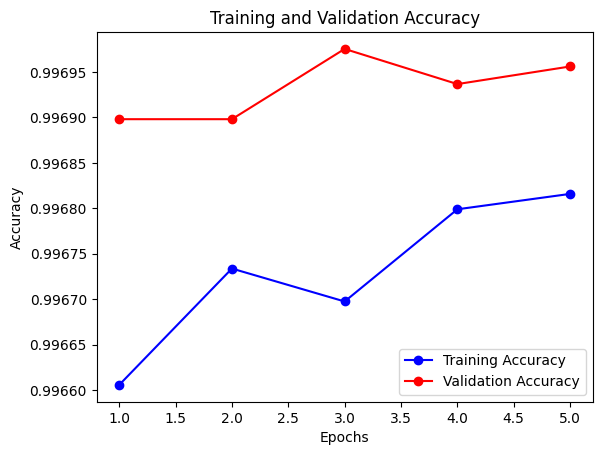

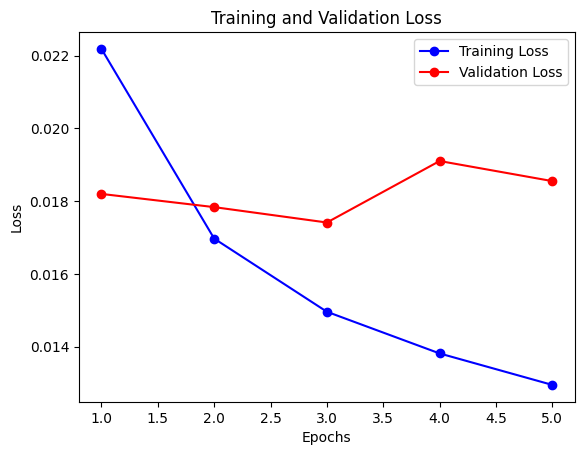

In [8]:
# Plot the training and validation metrics
plot_training_metrics(history, img_prefix='enron_spam_detection')



In [9]:
# Convert columns to string and handle NaN values
df['content'] = df['content'].fillna('').astype(str)
df['Subject'] = df['Subject'].fillna('').astype(str)

# Additional Feature Engineering
df['text_length'] = df['content'].apply(len)
df['subject_length'] = df['Subject'].apply(len)
df['count_exclamation'] = df['content'].apply(lambda x: x.count('!'))
df['count_links'] = df['content'].apply(lambda x: len(re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', x)))

# Combine and clean text data
df['Text'] = df['Subject'] + ' ' + df['content']
df['Text'] = df['Text'].apply(clean_text)

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# Preparing the text data
tfidf_vectorizer = TfidfVectorizer(max_features=10000)  # you can adjust the number of features
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Text'])

# Converting to DataFrame to concatenate with other features
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Concatenate TF-IDF features with engineered features
X = pd.concat([tfidf_df, df[['text_length', 'subject_length', 'count_exclamation', 'count_links']]], axis=1)
y = df['Label']  # Assuming 'Label' is your target variable

# RFE with RandomForestClassifier
forest = RandomForestClassifier()
rfe = RFE(estimator=forest, n_features_to_select=10, step=1)
rfe.fit(X, y)

# Transform X to the selected features
X_transformed = rfe.transform(X)




TypeError: object of type 'float' has no len()

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# Function to create model, required for KerasClassifier
def create_model(dropout_rate=0.0, optimizer='adam'):
    model = Sequential()
    model.add(Embedding(MAX_WORDS, 128, input_length=MAX_LEN))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(LSTM(64))
    model.add(Dropout(dropout_rate))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [10, 20, 50]
epochs = [10, 50, 100]
dropout_rate = [0.1, 0.5, 0.9]
optimizer = ['Adam', 'Nadam', 'SGD']

param_grid = dict(batch_size=batch_size, epochs=epochs, dropout_rate=dropout_rate, optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


In [ ]:
from sklearn.model_selection import cross_val_score

# Use the cross_val_score function
scores = cross_val_score(model, X, y, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())
